# Neutron Burst

The neutron burst may happen in high mass stars during a supernova blast leaving behind characteristic nucleosynthesis signatures in presolar grains. The neutron burst occurs when neutron number densities are sufficiently high ($\sim 10^{17}$ neutrons/cm$^{-3}$) to capture up an isotopic chain in a manner similar to the r-process, though with much lower neutron exposures and therefore less neutron rich products. 

For a glipse at this kind of network, consider the following neutron capture chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}

To solve this network numerically we have the coupled differential equations:
\begin{gather}
\frac{dY_1}{d\tau} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{d\tau} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{d\tau} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{d\tau} = \sigma_{n,3} Y_3 
\end{gather}
where the $\sigma_n$ are the neutron capture cross sections for each species and $\tau$ is the neutron exposure (units of inverse area). 

For simplicity, this notebook considers an isolated reaction chain. In other words the only reactions considered are neutron captures along the chain and out of the chain.

## Solving the network 

We begin by importing the necessary libraries:

In [1]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy','wnutils', 'wnnet', 'matplotlib', 'gslconsts', 'scipy', 'ipywidgets', 'xmlcoll'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
import wnutils.xml as wx
import xmlcoll as xc
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
from gslconsts.consts import *
from scipy.integrate import solve_ivp

Now we define a function to integrate the network numerically:

In [2]:
def dYdt(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

Now, we import the data that will be used throughout this notebook. Execution of this cell will take a minute. The 'solar_xml' contains the mass fractions of isotopes in the solar system and the 'net' contains details on nuclear reaction rates for computing the neutron burst network. 

In [3]:
solar_xml = wx.Xml(
        io.BytesIO(requests.get("https://osf.io/w8ktc/download").content))
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

### Getting the initial abundances

As a starting point, we will take the initial abundances to be that of solar (Lodders 2020). To obtain the abundances we define a function that uses the 'solar_xml' to obtain the mass fractions when given a list of isotopes in the chain:

In [4]:
def get_solar_isotopes(isotopes):    
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    abunds = []
    a = []
    d = {}

    for isotope in isotopes:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        if s_tup in x_solar:
            a.append(s_tup[2])
            abunds.append(x_solar[s_tup] / tup[1])
            d[s_tup[0]] = x_solar[s_tup] / tup[1]
            
    return a, d, abunds

Now we define a list of isotopes.  This is our network.  We also created a list of mass number for those isotopes.

In [5]:
species = ['ca40','ca41','ca42','ca43','ca44','ca45','ca46','ca47','ca48','ca49','ca50']
a_species = []
nucs = net.get_nuclides()
for sp in species:
    assert sp in nucs
    a_species.append(nucs[sp]['a'])

Now we use the get_solar_isotopes function to populate the abundance dictionary. The keys will be the isotope names and the value will be the abundances:

In [6]:
a_solar, d_solar, solar_abunds = get_solar_isotopes(species)
    
isotope_abunds = np.zeros(len(species))
for k, v in d_solar.items():
    isotope_abunds[species.index(k)] = v

Finally, we can plot the initial abundances.

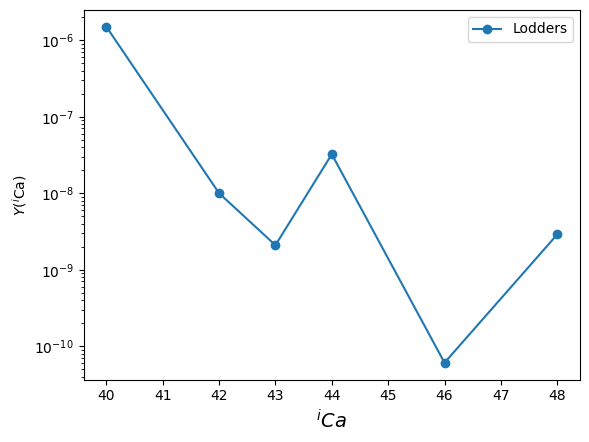

In [7]:
fig, ax = plt.subplots()
ax.plot(a_solar, solar_abunds, 'o-', label = 'Lodders')
ax.set_yscale('log')
ax.set_xlabel(r'$^{i} Ca$', fontsize = 14)
ax.set_ylabel(r'$Y$($^i$Ca)') 
ax.legend()
plt.show()

### Plotting the abundances vs. neutron exposure 

We can use the initial abundances and the scipy.integrate function to solve the system of ODE's presented above. In order to do this we need to obtain the neutron capture cross sections ($\sigma_i$) using the wnnet package. 

First, we define a temperature in $10^9$K to be used to compute the reaction rates.

In [8]:
t9 = 1

Now, we compute the reaction rates for all neutron capture reactions at the provided temperature:

In [9]:
induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
reacs = net.compute_rates(t9, reac_xpath = induced_reac_xpath)
rates = []
for key, values in list(reacs.items()):
    rates.append(values[0])

Next, we can obtain a dictionary of the reactions for strictly the species in our reaction chain: 

In [10]:
ordered_dict = {}

for sp in species:
    for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
        if sp in value.reactants:
            ordered_dict[sp] = reacs[key][0]

Now that we have obtained the rates, we can get the cross sections by noting:
\begin{gather}
r(T) = N_A <\sigma v>(T)
\end{gather}
and the thermal velocity is given by:
\begin{gather}
v_T = \sqrt{\frac{2k_BT}{m_n}}
\end{gather}
which represents the most probable velocity in a Maxwell-Boltzmann distribution. We then compute the cross sections:

In [11]:
k = GSL_CONST_CGS_BOLTZMANN
N_A = GSL_CONST_NUM_AVOGADRO
m_n = GSL_CONST_CGS_MASS_NEUTRON

T = t9 * 10**9
v_T = np.sqrt((2*k*T)/m_n)

sigs_array = []
for key, value in ordered_dict.items():
    sigs_array.append(1000*value/(v_T*N_A*wn.consts.GSL_CONST_CGSM_BARN))

[3.6375856388906236, 14.446229923346499, 9.177022224162583, 22.748183943654688, 4.9103944545645115, 7.4188731239488055, 2.3254372260120926, 1.8903923035687826, 0.5086302125267839, 0.5471526080928719, 0.2267046013826623]


Finally we solve the network and plot the results:

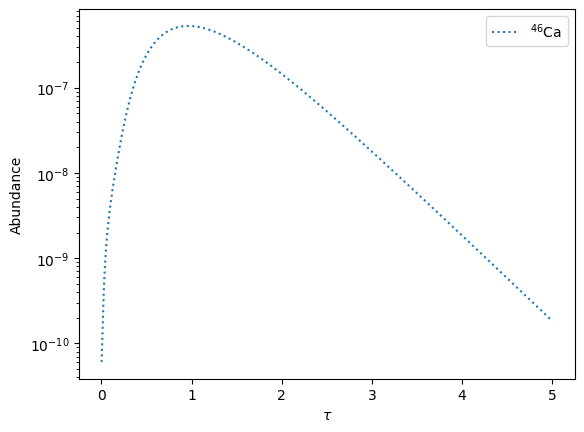

In [12]:
tau = np.linspace(0.001, 5, 100)

sol = solve_ivp(dYdt, [tau[0], tau[len(tau)-1]], isotope_abunds, args=(sigs_array,), max_step=0.001)

#plot results
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[species.index('ca46'), :], ':', label = solar_xml.get_latex_names(['ca46'])['ca46'])
ax.set_yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abundance')
plt.show()

### Exploring final abundances 
Now we would like to explore the final abundances of all isotopes in the chain subject to different exposures. One would also likely want initial abundances to be near solar, however varying the initial compositions can impact the final abundances to more accurately describe the abundances observed in presolar grains. 

Now, we create the interactive plot. The widgets can be used to vary the neutron exposure $\tau$:

In [13]:
def plot_nuclear_network(tau, abunds):

    sol = solve_ivp(dYdt, (0, tau), abunds, args=(sigs_array,), max_step=0.001)

    fig, ax = plt.subplots()
    ax.plot(a_solar, solar_abunds, 'o:', label="Lodders")

    ax.plot(a_species, sol.y[:,-1], 'o-', label = 'Network')
    #ax.set_xticks(range(min(a), max(a) + 1, 1))
    ax.set_xlabel(r'$^{i}Ca$')  #Modify element symbol for different abundance chain
    ax.set_ylabel('Abundance')
    ax.set_title('$\\tau$ = {:.3f} $mb^{{-1}}$'.format(tau))
    ax.set_yscale('log')
    ax.set_ylim([1.e-12, 1.e-5])
    ax.legend()
    plt.show()
    ax.clear()

interact(
    plot_nuclear_network,
    tau=widgets.BoundedFloatText(value=0.0, min=0.0, max=5.0, step=0.001, description='τ'),
    abunds=fixed(isotope_abunds),
)

interactive(children=(BoundedFloatText(value=0.0, description='τ', max=5.0, step=0.001), Output()), _dom_class…

<function __main__.plot_nuclear_network(tau, abunds)>

## Comparison to data
Here we compare the results of the neutron burst network calculation to that of presolar grain data. Grain data is reported in abundance ratios or by $\delta$ values given by for example a calcium isotope:
\begin{gather}
\delta(^{i}Ca) = \Big(\frac{\big(\frac{^iCa}{^{40}Ca} \big)_{meas}}{\big(\frac{^iCa}{^{40}Ca} \big)_{std}} -1\Big)\times 10^3 
\end{gather}

This relationship allows for us to compare grain data (reported in $\delta$ values) to network results. To make the comparison, enter a list of grain data.  Each entry in the list is a dictionary with entries for the grain *name*, a list giving the mass number of each isotop for which there are data, a list giving the delta values, and a list giving the error on the delta values.  The last line of the cell checks for consistency of the input by checking that the length of each list is the same for each grain.

In [14]:
normalizing_species = 'ca40'

grains = [
#    {'name': 'grain 1',
#     'a': [40, 42, 43, 44, 46, 48],
#     'data': [0, 318, 1488, 98., 34091, -235],
#     'error': [0.001, 44, 141, 23, 221, 4]
#    },
    {'name' : 'grain 2',
      'a': [40, 42, 43, 44, 46, 48],
      'data': [1.03e-2, 121, -58, -30, 1185, -235],
      'error': [1.4e-3, 29, 87, 15, 367, 41] 
    },
#    {'name' : 'grain 3',
#     'a': [40, 42, 43, 44, 46, 48],
#     'data': [4.45e-3, 156, 210, -19, 3165, -232],
#     'error': [6.03e-4, 28, 87, 16, 383, 41]
#    },
    {'name' : 'grain 4',
     'a': [40, 42, 43, 44, 46, 48],
     'data': [9.49e-3, 167, 105, 17, 830, -187],
     'error': [1.29e-3, 30, 79, 17, 276, 44]
    },
#    {'name' : 'grain 5',
#     'a': [40, 42, 43, 44, 46, 48],
#     'data': [5.49e-3, 235, 680, 13, 14255, 537],
#     'error': [7.43e-4, 63, 271, 33, 2415, 128]} 
]

for g in grains:
    assert len(g['a']) == len(g['data']) == len(g['error'])

Graph the grain data and network results as a function of mass number for varying neutron exposure $\tau$ in units of inverse millibarns.

In [15]:
def compare_nuclear_network(tau, isotope_abundances):
    sol = solve_ivp(dYdt, (0, tau), isotope_abunds, args=(sigs_array,), max_step=0.001)
    
    delta = []
    for sp in d_solar:
        delta.append(1000 * ((sol.y[species.index(sp), -1] / d_solar[sp]) / 
                             (sol.y[species.index(normalizing_species),-1] / d_solar[normalizing_species]) - 1))
    
    fig, ax = plt.subplots()
    
    for g in grains:
        ax.errorbar(g['a'], g['data'], yerr = g['error'], fmt = 'o', label = g['name'])

    ax.plot(a_solar, delta, 'o:', label="Network")
    ax.plot(a_solar, np.zeros(len(a_solar)), '--', color='black', linewidth = 0.5)
    ax.set_xlabel('Mass Number')  #Modify element symbol for different abundance chain
    ax.set_ylabel('$\\delta$')
    ax.set_title('$\\tau$ = {:.3f} $mb^{{-1}}$'.format(tau))
    ax.legend()
    plt.show()
    ax.clear()
    
interact(
    compare_nuclear_network,
    tau=widgets.BoundedFloatText(value=.0, min=0.0, max=5, step=0.001, description='τ'),
    isotope_abundances=fixed(isotope_abunds),
    #**sliders
)

interactive(children=(BoundedFloatText(value=0.0, description='τ', max=5.0, step=0.001), Output()), _dom_class…

<function __main__.compare_nuclear_network(tau, isotope_abundances)>

# Mixing layers of different exposures
The python package [layerspy](https://github.com/lucaswalls18/layerspy) provides functionality for combining, manipulating, and mixing data than can be imagined as a "layer." Here we can consider any given exposure $\tau$ to be a layer. In this layer there will be an abundance pattern associated with the solution to the neutron burst network at the given $\tau$. Since mixing will occur in the ejecta of supernovae and further since exposure is not homogenous throughout the explosion it is important to look at what yields could be created from such mixtures. 

We begin by importing the layerspy library and defining a dictionary which will hold the layer data: 

In [16]:
import layerspy as ly

abund_tau_dict = {}
tau = np.linspace(0.01,0.07,100)

for t in tau:
    abund_tau_dict[str(t)] = {}
    sol = solve_ivp(dYdt, (0,t), isotope_abunds, args=(sigs_array,), t_eval = [t], max_step = 0.001)
    abund_tau_dict[str(t)]["properties"] = {}
    abund_tau_dict[str(t)]["mass fractions"] = {}
    for sp in species:
        abund_tau_dict[str(t)]["properties"]['tau'] = 1/t
        abund_tau_dict[str(t)]["properties"]['ca43'] = (sol.y[species.index('ca43')])[0]
        abund_tau_dict[str(t)]["mass fractions"][sp] = (sol.y[species.index(sp)])[0]

In [17]:
tau_layers = ly.Layer(abund_tau_dict)
weight_dict = tau_layers.make_weight_dict(prop = 'tau')
mixture = tau_layers.make_mixed_layer(weight_dict)

In [18]:
data = mixture.get_zone_data()['mixture']['mass fractions']

In [19]:
delta_mixture = []
for sp in d_solar:
    delta_mixture.append(1000*(data[sp]/d_solar[sp] * d_solar[normalizing_species]/data[normalizing_species]-1))

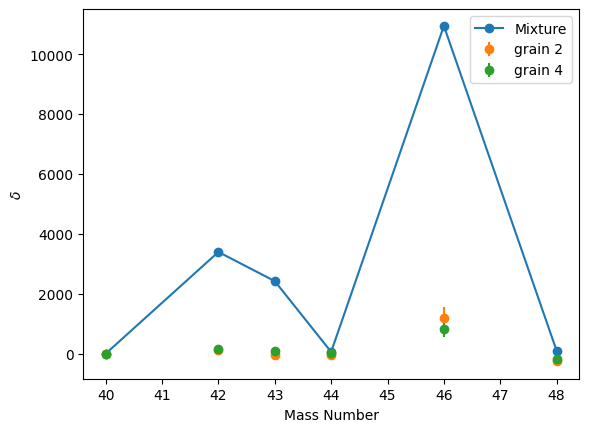

In [20]:
fig, ax = plt.subplots()
ax.plot(a_solar, delta_mixture, 'o-', label = 'Mixture')
for g in grains:
    ax.errorbar(g['a'], g['data'], yerr = g['error'], fmt = 'o', label = g['name'])
ax.set_xlabel('Mass Number')
ax.set_ylabel('$\delta$')
ax.legend()
plt.show()